In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import lfilter,correlate
import tensorflow.keras.layers as tfl
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau

2024-06-17 19:39:35.490786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 19:39:35.490881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 19:39:35.654275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def pre_emphasis(signal,factor=0.97):
    return np.append(signal[0], signal[1:] - factor * signal[:-1])

In [3]:
def inverse_filtering(signal, lpc_coeffs):
    return lfilter(np.concatenate(([1], -lpc_coeffs[1:])), [1], signal)

In [4]:
def compute_lpc(signal, order):
    autocorr = correlate(signal, signal, mode='full')
    autocorr = autocorr[len(signal)-1:len(signal)+order]
    
    a = np.concatenate(([1], -autocorr[1:order+1]))
    b = [1]
    
    lpc_coeffs = lfilter(b, a, signal)
    
    lpc_coeffs = np.concatenate(([1], -lpc_coeffs[1:order+1]))
    
    del autocorr,a,b
    
    return lpc_coeffs

In [5]:
def lpc_to_cepstrum(lpc_coeffs):
    return np.fft.ifft(np.log(np.abs(np.fft.fft(lpc_coeffs))))

In [6]:
import gc
from IPython.display import clear_output

def create_spectrograms(train_folder, create_folder, verbose=False, speakers=50, utterances=10, sr=7000, frame_length=2048, hop_length=512, lpc_order=16):
    spc_folder = os.path.join(create_folder, "spectrogram")
    vt_folder = os.path.join(create_folder, "vocal_tract")
    glot_folder = os.path.join(create_folder, "glottal")
    
    total_speaker = 0
    for speaker in os.listdir(train_folder):
        total_utterances = 0
        speaker_folder_spc = os.path.join(spc_folder, speaker)
        speaker_folder_vt = os.path.join(vt_folder, speaker)
        speaker_folder_glot = os.path.join(glot_folder, speaker)
        os.makedirs(speaker_folder_spc, exist_ok=True)
        os.makedirs(speaker_folder_vt, exist_ok=True)
        os.makedirs(speaker_folder_glot, exist_ok=True)
        
        for vidID in os.listdir(os.path.join(train_folder, speaker)):
            for file in os.listdir(os.path.join(train_folder, speaker, vidID)):
                if file.endswith(".wav"):
                    wav_file_path = os.path.join(train_folder, speaker, vidID, file)
                    
                    y, sr = librosa.load(wav_file_path, sr=sr)
                    
#                     y_preemphasized=pre_emphasis(y)
                    y_preemphasized=y
                    
                    frames = librosa.util.frame(y_preemphasized, frame_length=frame_length, hop_length=hop_length).T
                    del y_preemphasized
                    
                    window = np.hamming(frame_length)
                    frames_windowed = frames * window  
                    del frames
                    
                    lpc_coeffs = []
                    for frame in frames_windowed:
                        frame=np.array(frame)
                        coeff = compute_lpc(frame, lpc_order)
                        lpc_coeffs.append(coeff)
                        
                    glottal_waveforms = [inverse_filtering(frame, coeff) for frame, coeff in zip(frames_windowed, lpc_coeffs)]
                    glottal_waveforms_avg = np.mean(np.abs(np.array(glottal_waveforms)), axis=0)
                    del glottal_waveforms
                    
                    residuals = []
                    for i, coeff in enumerate(lpc_coeffs):
                        frame = frames_windowed[i]
                        residual = lfilter(coeff, [1.0], frame)
                        residuals.append(residual)
                        
                    residual_avg = np.mean(np.abs(np.array(residuals)), axis=0)
                    
                    del frames_windowed, lpc_coeffs, residuals
                    gc.collect()

                    try:
                        plt.figure(figsize=(5, 5))
                        ax = plt.axes()
                        ax.set_axis_off()
                        plt.set_cmap('hot')
                        amp=np.abs(librosa.stft(y))
                        D = librosa.amplitude_to_db(amp, ref=np.max)
                        del y,amp
                        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
                        output_path = os.path.join(speaker_folder_spc, "spc"+str(total_utterances+1) + ".png")
                        plt.savefig(output_path, bbox_inches='tight', transparent=True, pad_inches=0.0)
                        plt.close('all')
                        del D,ax,output_path
                        gc.collect()

                        plt.figure(figsize=(5, 5))
                        ax = plt.axes()
                        ax.set_axis_off()
                        plt.set_cmap('hot')
                        amp=np.abs(librosa.stft(residual_avg))
                        D_residual = librosa.amplitude_to_db(amp, ref=np.max)
                        del amp
                        librosa.display.specshow(D_residual, sr=sr, x_axis='time', y_axis='log')
                        output_path = os.path.join(speaker_folder_vt, "vt"+str(total_utterances+1) + ".png")
                        plt.savefig(output_path, bbox_inches='tight', transparent=True, pad_inches=0.0)
                        plt.close('all')
                        del D_residual,ax,output_path
                        gc.collect()

                        plt.figure(figsize=(5, 5))
                        ax = plt.axes()
                        ax.set_axis_off()
                        plt.set_cmap('hot')
                        amp=np.abs(librosa.stft(glottal_waveforms_avg))
                        D_glot = librosa.amplitude_to_db(amp, ref=np.max)
                        del amp
                        librosa.display.specshow(D_glot, sr=sr, x_axis='time', y_axis='log')
                        output_path = os.path.join(speaker_folder_glot, "glot"+str(total_utterances+1) + ".png")
                        plt.savefig(output_path, bbox_inches='tight', transparent=True, pad_inches=0.0)
                        plt.close('all')
                        del D_glot,ax,output_path
                        gc.collect()
                        
#                         clear_output()
                    
                    except OSError as e:
                        print(f"Error saving spectrogram for {wav_file_path}: {e}")
                    
                    del residual_avg, glottal_waveforms_avg
                    gc.collect()
    
                    total_utterances += 1
                    if total_utterances == utterances:
                        break
            
            if total_utterances == utterances:
                break
        
        total_speaker += 1
        if total_speaker != 0 and total_speaker % 1 == 0 and verbose:
            print(f"{total_speaker} speakers completed.\n")
        
        if total_speaker == speakers:
            break

In [7]:
raw_dataset_loc="/kaggle/input/voxceleb1train/wav"
save_loc="/kaggle/working/"
num_speakers=5
num_utterances=100

In [8]:
create_spectrograms(raw_dataset_loc,save_loc,True,num_speakers,num_utterances)

1 speakers completed.

2 speakers completed.

3 speakers completed.

4 speakers completed.

5 speakers completed.



In [8]:
del plt,librosa

In [9]:
from PIL import Image

dataset_path_spc="/kaggle/working/spectrogram"
dataset_path_vt="/kaggle/working/vocal_tract"
dataset_path_glot="/kaggle/working/glottal"
folders=os.listdir(dataset_path_spc)

# Initializing training and test dataset
X_train=[[],[],[]]
y_train=[[],[],[]]
X_test=[[],[],[]]
y_test=[[],[],[]]

# Split the dataset into training and test set.
num=np.random.rand(num_utterances*num_speakers)
mask=num<0.2
split=mask.astype(int)

for dirs in folders:
    i=0
    for img in os.listdir(os.path.join(dataset_path_spc,dirs)):
        image=Image.open(os.path.join(dataset_path_spc,dirs,img))
        new_img=image.resize((200,200))
        tmp_array=np.array(new_img)/255.
        if split[i]==0:
            X_train[0].append(tmp_array)
            y_train[0].append(str(dirs))
        else:
            X_test[0].append(tmp_array)
            y_test[0].append(str(dirs))
            
        i+=1
        
    i=0    
    for img in os.listdir(os.path.join(dataset_path_vt,dirs)):
        image=Image.open(os.path.join(dataset_path_vt,dirs,img))
        new_img=image.resize((200,200))
        tmp_array=np.array(new_img)/255.
        if split[i]==0:
            X_train[1].append(tmp_array)
            y_train[1].append(str(dirs))
        else:
            X_test[1].append(tmp_array)
            y_test[1].append(str(dirs))
            
        i+=1
            
    i=0
    for img in os.listdir(os.path.join(dataset_path_glot,dirs)):
        image=Image.open(os.path.join(dataset_path_glot,dirs,img))
        new_img=image.resize((200,200))
        tmp_array=np.array(new_img)/255.
        if split[i]==0:
            X_train[2].append(tmp_array)
            y_train[2].append(str(dirs))
        else:
            X_test[2].append(tmp_array)
            y_test[2].append(str(dirs))
        
        i+=1

In [10]:
dict={}
i=0
for val in folders:
    dict[val]=i
    i=i+1

dict

{'id10484': 0, 'id11079': 1, 'id11123': 2, 'id10459': 3, 'id10116': 4}

In [11]:
i=0
for _ in y_train[0]:
    y_train[0][i]=dict[y_train[0][i]]
    i=i+1

i=0
for _ in y_test[0]:
    y_test[0][i]=dict[y_test[0][i]]
    i=i+1
    
i=0
for _ in y_train[1]:
    y_train[1][i]=dict[y_train[1][i]]
    i=i+1

i=0
for _ in y_test[1]:
    y_test[1][i]=dict[y_test[1][i]]
    i=i+1
    
i=0
for _ in y_train[2]:
    y_train[2][i]=dict[y_train[2][i]]
    i=i+1

i=0
for _ in y_test[2]:
    y_test[2][i]=dict[y_test[2][i]]
    i=i+1

In [12]:
def convolutional_model(input_shape,output_shape):
    input_img = tf.keras.Input(shape=input_shape)
    Z1=tfl.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='same')(input_img)
    A1=tfl.ReLU()(Z1)
    P1=tfl.MaxPool2D(pool_size=(4,4),padding='same')(A1)
    Z2=tfl.Conv2D(filters=64,kernel_size=(2,2),strides=(1,1),padding='same')(P1)
    A2=tfl.ReLU()(Z2)
    P2=tfl.MaxPool2D(pool_size=(4,4),padding='same')(A2)
    Z3=tfl.Conv2D(filters=128,kernel_size=(2,2),strides=(1,1),padding='same')(P2)
    A3=tfl.ReLU()(Z3)
    P3=tfl.MaxPool2D(pool_size=(4,4),padding='same')(A3)
    F=tfl.Flatten()(P3)
    D1=tfl.Dense(128)(F)
    DP1=tfl.Dropout(0.5)(D1)
    
    outputs=tfl.Dense(output_shape,activation='softmax')(DP1)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [14]:
conv_model_spc = convolutional_model((200, 200, 4),num_speakers)
conv_model_spc.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train[0], y_train[0])).batch(16)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test[0], y_test[0])).batch(16)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)

# history = model1.fit(xtrain, ytrain, batch_size=64, epochs=100, validation_data=(xval, yval), callbacks=(reduce_lr,chk_pt))
history = conv_model_spc.fit(np.array(X_train[0]),np.array(y_train[0]), batch_size=32, epochs=100, validation_data=(np.array(X_test[0]),np.array(y_test[0])),callbacks=(reduce_lr))

Epoch 1/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2453 - loss: 1.7158

I0000 00:00:1718654806.945334     122 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718654806.963249     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.2493 - loss: 1.6971

W0000 00:00:1718654811.581825     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718654812.357794     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 737ms/step - accuracy: 0.2497 - loss: 1.6935 - val_accuracy: 0.2706 - val_loss: 1.5148 - learning_rate: 0.0010
Epoch 2/100
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3281 - loss: 1.5373

W0000 00:00:1718654813.603629     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3350 - loss: 1.5277 - val_accuracy: 0.5412 - val_loss: 1.3226 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4769 - loss: 1.3392 - val_accuracy: 0.5882 - val_loss: 1.0516 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5597 - loss: 1.1199 - val_accuracy: 0.6000 - val_loss: 0.9403 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5550 - loss: 1.0963 - val_accuracy: 0.6353 - val_loss: 0.9257 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5306 - loss: 1.0872 - val_accuracy: 0.6471 - val_loss: 0.8449 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6506 - loss: 0.9245 - val_accuracy: 0.6824 - val_loss: 0.7704 - learning_rate: 0.0010
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6772 - loss: 0.7962 - val_accuracy

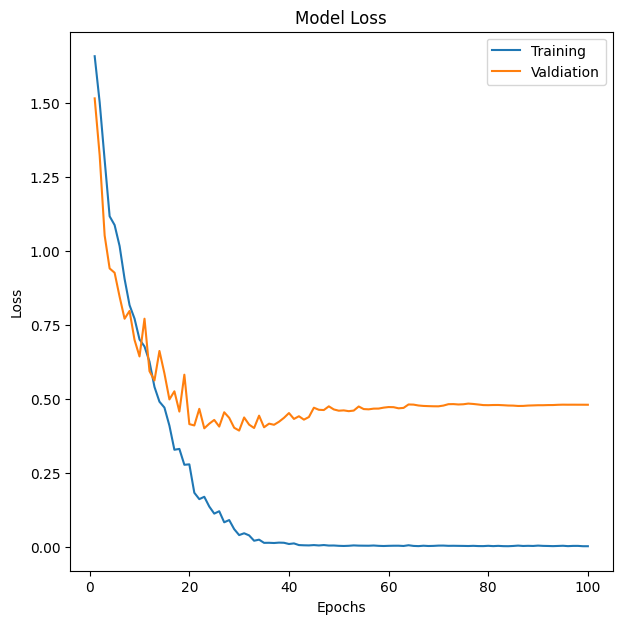

In [16]:
plt.figure(figsize=(7,7))
model_loss = history.history['loss']
model_val_loss = history.history['val_loss']
plt.plot(range(1,len(model_loss)+1), model_loss)
plt.plot(range(1,len(model_loss)+1), model_val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend(['Training', 'Valdiation'])
plt.show()
plt.close()

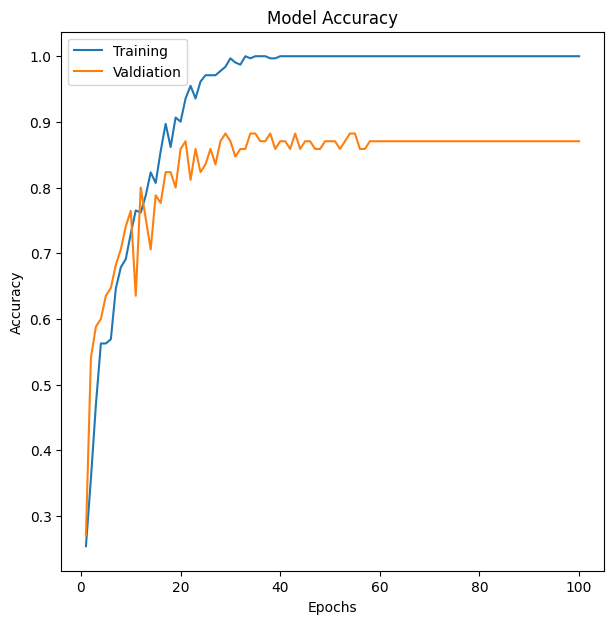

In [17]:
plt.figure(figsize=(7,7))
model_acc = history.history['accuracy']
model_val_acc = history.history['val_accuracy']
plt.plot(range(1,len(model_loss)+1), model_acc)
plt.plot(range(1,len(model_loss)+1), model_val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend(['Training', 'Valdiation'])
plt.show()
plt.close()

In [18]:
conv_model_glot = convolutional_model((200, 200, 4),num_speakers)
conv_model_glot.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [19]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train[0], y_train[0])).batch(16)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test[0], y_test[0])).batch(16)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)

# history = model1.fit(xtrain, ytrain, batch_size=64, epochs=100, validation_data=(xval, yval), callbacks=(reduce_lr,chk_pt))
history_glot = conv_model_glot.fit(np.array(X_train[2]),np.array(y_train[2]), batch_size=32, epochs=100, validation_data=(np.array(X_test[2]),np.array(y_test[2])),callbacks=(reduce_lr))

Epoch 1/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2488 - loss: 1.6865

W0000 00:00:1718654865.970655     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.2521 - loss: 1.6793

W0000 00:00:1718654868.673314     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718654869.332875     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step - accuracy: 0.2534 - loss: 1.6765 - val_accuracy: 0.2706 - val_loss: 1.5746 - learning_rate: 0.0010
Epoch 2/100
 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2702 - loss: 1.5958

W0000 00:00:1718654869.621836     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2604 - loss: 1.5849 - val_accuracy: 0.2706 - val_loss: 1.4932 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2251 - loss: 1.5806 - val_accuracy: 0.2706 - val_loss: 1.5456 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2756 - loss: 1.5671 - val_accuracy: 0.2824 - val_loss: 1.4940 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2235 - loss: 1.5569 - val_accuracy: 0.3647 - val_loss: 1.4665 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3241 - loss: 1.5457 - val_accuracy: 0.4588 - val_loss: 1.4276 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3409 - loss: 1.5104 - val_accuracy: 0.4706 - val_loss: 1.3575 - learning_rate: 0.0010
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3819 - loss: 1.4383 - val_accuracy

In [20]:
conv_model_vt = convolutional_model((200, 200, 4),num_speakers)
conv_model_vt.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [21]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train[0], y_train[0])).batch(16)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test[0], y_test[0])).batch(16)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)

# history = model1.fit(xtrain, ytrain, batch_size=64, epochs=100, validation_data=(xval, yval), callbacks=(reduce_lr,chk_pt))
history_vt = conv_model_vt.fit(np.array(X_train[1]),np.array(y_train[1]), batch_size=32, epochs=100, validation_data=(np.array(X_test[1]),np.array(y_test[1])),callbacks=(reduce_lr))

Epoch 1/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1839 - loss: 1.6586

W0000 00:00:1718654909.400882     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.1928 - loss: 1.6521

W0000 00:00:1718654912.493717     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718654913.270817     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 475ms/step - accuracy: 0.1961 - loss: 1.6495 - val_accuracy: 0.2706 - val_loss: 1.5737 - learning_rate: 0.0010
Epoch 2/100
 5/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2001 - loss: 1.5789

W0000 00:00:1718654913.688560     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2090 - loss: 1.5849 - val_accuracy: 0.2706 - val_loss: 1.5149 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2702 - loss: 1.5668 - val_accuracy: 0.2471 - val_loss: 1.4976 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2750 - loss: 1.5765 - val_accuracy: 0.2824 - val_loss: 1.4729 - learning_rate: 0.0010
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2890 - loss: 1.5364 - val_accuracy: 0.2118 - val_loss: 1.5063 - learning_rate: 0.0010
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3612 - loss: 1.5051 - val_accuracy: 0.3529 - val_loss: 1.4646 - learning_rate: 0.0010
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3438 - loss: 1.4778 - val_accuracy: 0.3412 - val_loss: 1.4426 - learning_rate: 0.0010
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3943 - loss: 1.4507 - val_accuracy

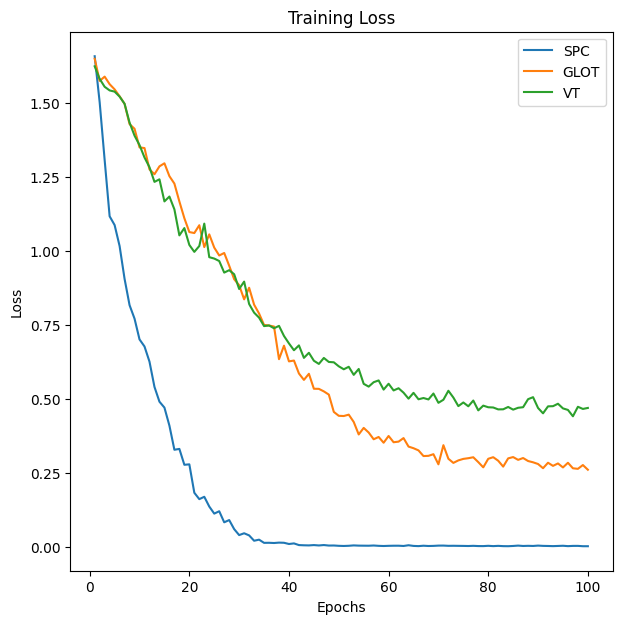

In [22]:
plt.figure(figsize=(7,7))
model_loss_spc = history.history['loss']
model_loss_glot = history_glot.history['loss']
model_loss_vt = history_vt.history['loss']
plt.plot(range(1,len(model_loss)+1), model_loss)
plt.plot(range(1,len(model_loss)+1), model_loss_glot)
plt.plot(range(1,len(model_loss)+1), model_loss_vt)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend(['SPC', 'GLOT', 'VT'])
plt.show()
plt.close()

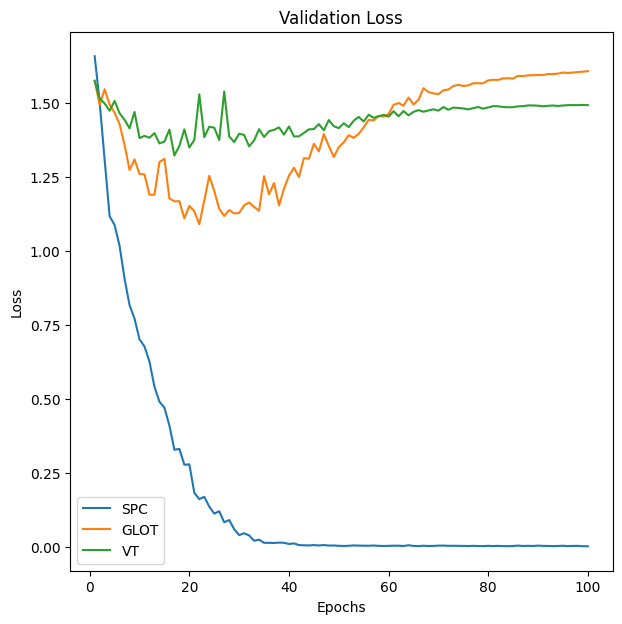

In [23]:
plt.figure(figsize=(7,7))
model_loss_spc = history.history['val_loss']
model_loss_glot = history_glot.history['val_loss']
model_loss_vt = history_vt.history['val_loss']
plt.plot(range(1,len(model_loss)+1), model_loss)
plt.plot(range(1,len(model_loss)+1), model_loss_glot)
plt.plot(range(1,len(model_loss)+1), model_loss_vt)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend(['SPC', 'GLOT', 'VT'])
plt.show()
plt.close()

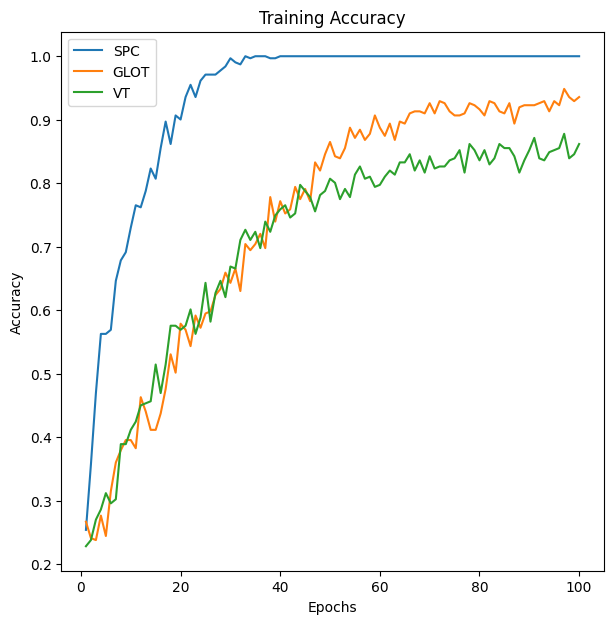

In [24]:
plt.figure(figsize=(7,7))
model_loss_spc = history.history['accuracy']
model_loss_glot = history_glot.history['accuracy']
model_loss_vt = history_vt.history['accuracy']
plt.plot(range(1,len(model_loss)+1), model_loss_spc)
plt.plot(range(1,len(model_loss)+1), model_loss_glot)
plt.plot(range(1,len(model_loss)+1), model_loss_vt)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend(['SPC', 'GLOT', 'VT'])
plt.show()
plt.close()

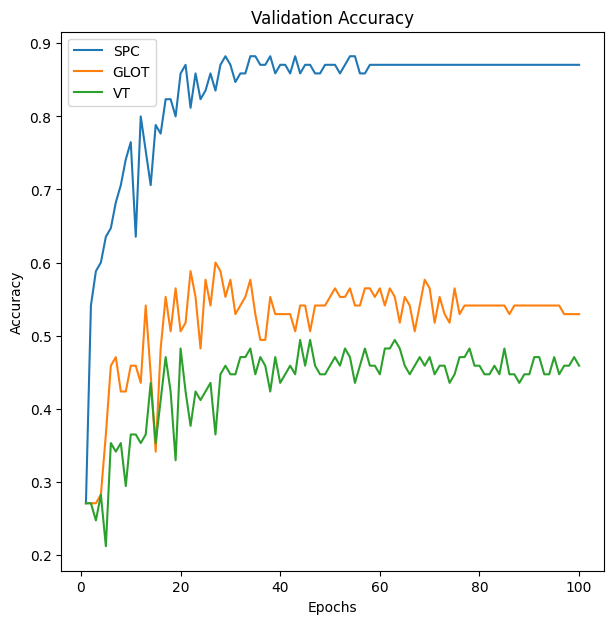

In [25]:
plt.figure(figsize=(7,7))
model_loss_spc = history.history['val_accuracy']
model_loss_glot = history_glot.history['val_accuracy']
model_loss_vt = history_vt.history['val_accuracy']
plt.plot(range(1,len(model_loss)+1), model_loss_spc)
plt.plot(range(1,len(model_loss)+1), model_loss_glot)
plt.plot(range(1,len(model_loss)+1), model_loss_vt)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend(['SPC', 'GLOT', 'VT'])
plt.show()
plt.close()

In [62]:
import zipfile

# Define the paths
source_path = '/kaggle/working'  # Source directory in Kaggle
zip_filename = 'saved_data.zip'  # Name for the zip file

# Create a zip archive
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Add all files in source_path to the zip
    for root, _, files in os.walk(source_path):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), source_path))


In [ ]:
globals().clear()

In [ ]:
locals().clear()